## XRP Price Forecasting and Strategy Simulation with an MLP Baseline

This notebook explores the predictive capability of a simple feedforward neural network (MLP) for short-term forecasting of XRP cryptocurrency prices. We use lagged hourly price data to train a one-step-ahead model and evaluate its performance both statistically and practically.

The workflow includes:

- Data loading and hourly resampling
- Feature construction using lagged closing prices
- Model training and evaluation using RMSE, MAE, and $R^2$
- Visual analysis of predicted vs. true prices
- Post-hoc bias correction
- Construction of a threshold-based trading strategy
- Benchmarking against a buy-and-hold approach
- Return analysis and risk-adjusted performance (Sharpe ratio)

Although the MLP model achieves high accuracy on traditional regression metrics, its trading performance under a naive threshold strategy underperforms the market. This outcome highlights the gap between statistical prediction and actionable trading logic.

The notebook serves as a reproducible baseline for neural network-based modeling in the crypto space, laying the groundwork for deeper architectures and more sophisticated strategies in future research.

In [1]:
# ========== Setup ==========
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

# ========== Core Libraries ==========
import numpy as np
import pandas as pd

# ========== Visualization ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Preprocessing & Evaluation ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# ========== Deep Learning (TensorFlow/Keras) ==========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ========== Reproducibility ==========
import random
random.seed(12)
np.random.seed(12)
tf.random.set_seed(12)

### Load and Resample XRP Data

We begin by importing the raw XRP price dataset, which includes open, high, low, close, and volume information recorded at one-minute intervals. For the purposes of this analysis, we resample the data to an hourly frequency, retaining only the final closing price within each hour. This gives us a more manageable view of price movements and reduces short-term noise, making the series better suited for forecasting and trading strategy simulations.

Visualizing the resulting series helps verify the structure and continuity of the hourly data.

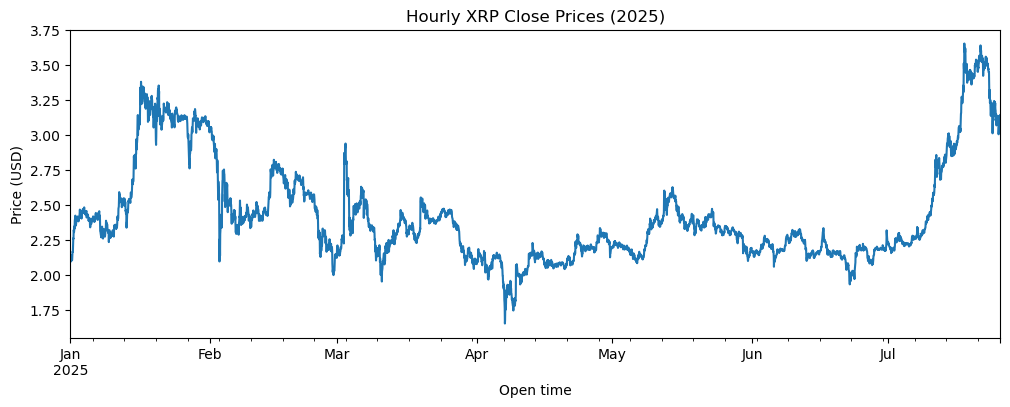

In [2]:
# Read the raw dataset of XRP price history (2025) and parse timestamps
df = pd.read_csv("xrpdata_2025.csv", parse_dates=["Open time"])
df.set_index("Open time", inplace=True)

# Resample the data to obtain hourly closing prices
df_hourly = df["Close"].resample("1h").last().dropna()

# Quick plot to visually confirm correct resampling
df_hourly.plot(title="Hourly XRP Close Prices (2025)", figsize=(12, 4))
plt.ylabel("Price (USD)")
plt.show()

### Feature Engineering: Lagged Observations

To frame the forecasting task as supervised learning, we construct lagged features from the hourly closing price series. Specifically, we predict the closing price at time $t$ using the prices at $t-1$, $t-2$, and $t-3$. This approach allows the model to learn patterns in short-term temporal dependencies, a common technique in time series forecasting.

We discard any rows with missing values caused by the shifting operation.

In [3]:
# Construct a DataFrame where each row includes the current hour's closing price (t)
# and the three preceding hourly values as features (t-1, t-2, t-3)
df_model = pd.DataFrame({
    't': df_hourly,
    't-1': df_hourly.shift(1),
    't-2': df_hourly.shift(2),
    't-3': df_hourly.shift(3)
})

# Drop rows with NaN values introduced by shifting
df_model.dropna(inplace=True)

# Define feature matrix X and target vector y
X = df_model[['t-1', 't-2', 't-3']].values
y = df_model['t'].values

### Train-Test Split and Scaling

We divide the dataset into training and testing subsets using a single chronological split, keeping the last 20% of observations as the test set. Shuffling is explicitly disabled to preserve the temporal ordering of the data, a requirement for realistic time series forecasting.

Although k-fold cross-validation is common in many machine learning tasks, it is not always appropriate for time-dependent data, where leakage from future information can bias the results. A single, forward-respecting split ensures that the model is trained only on "past" data and evaluated on "future" data, mirroring real-world forecasting conditions. For more rigorous model creation, we would utilize **rolling-window validation** or **walk-forward analysis**, which simulate a live forecasting environment by repeatedly retraining the model on expanding historical windows and testing on the next unseen point.

Feature scaling is performed using standard z-score normalization, applied only to the input features and fitted on the training set to prevent data leakage. The target variable $y$ is left unscaled to preserve interpretability, since we are forecasting real-world prices in USD. Although cryptocurrency prices can exhibit substantial volatility, the overall price range in this dataset remains moderate, allowing the model to learn effectively without the need for target transformation.

In [4]:
# Perform a chronological split of the data (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=12
)

# Standardize features using z-score normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Definition: Feedforward Neural Network

We use a simple feedforward neural network (multilayer perceptron, or MLP) for one-step-ahead price forecasting. The model consists of two hidden layers with 64 units each and ReLU activations, followed by a single output neuron for regression.

This architecture was chosen to balance model capacity and computational efficiency, providing enough nonlinearity to capture short-term patterns in price dynamics. We compile the model with the Adam optimizer, using mean squared error (MSE) as the loss function and mean absolute error (MAE) as an additional evaluation metric.

TensorFlow system logs and hardware-level warnings (e.g., related to GPU or NUMA configuration) are suppressed for clarity during training.

In [5]:
model = keras.Sequential([
    # First hidden layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    
    # Second hidden layer
    layers.Dense(64, activation='relu'),
    
    # Output layer with a single neuron for regression
    layers.Dense(1)
])

# Compile the model using Adam optimizer and MSE loss
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']  # Mean Absolute Error gives interpretable units (dollars)
)

### Model Training

The model is trained using the Adam optimizer and mean squared error (MSE) loss over a maximum of 50 epochs. We reserve 10% of the training set as a validation set to monitor performance on unseen data during training. This allows us to detect signs of overfitting and evaluate generalization without touching the test set.

To improve efficiency and prevent overfitting, we use early stopping with a patience of 5 epochs. This halts training when validation loss no longer improves, and restores the model weights from the epoch with the best performance.

Epoch progress is displayed with loss and mean absolute error (MAE) for both the training and validation subsets.

In [6]:
# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


I0000 00:00:1754428575.553021  196265 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 [==============================] - 1s 2ms/step - loss: 1.5984 - mae: 1.0353 - val_loss: 0.0195 - val_mae: 0.1142
Epoch 2/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0172 - mae: 0.0833 - val_loss: 0.0032 - val_mae: 0.0499
Epoch 3/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0042 - mae: 0.0438 - val_loss: 0.0012 - val_mae: 0.0284
Epoch 4/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0022 - mae: 0.0311 - val_loss: 4.7096e-04 - val_mae: 0.0154
Epoch 5/50
112/112 [==============================] - 0s 4ms/step - loss: 0.0015 - mae: 0.0256 - val_loss: 4.7680e-04 - val_mae: 0.0162
Epoch 6/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0227 - val_loss: 4.6459e-04 - val_mae: 0.0166
Epoch 7/50
112/112 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0227 - val_loss: 2.7766e-04 - val_mae: 0.0124
Epoch 8/50
112/112 [==============================] - 0s 2ms/step - los

### Training Curve

The following plot shows how the model's mean squared error (MSE) evolved across training epochs, both for the training set and the validation subset. This helps visualize the learning behavior and diagnose potential issues like underfitting or overfitting.

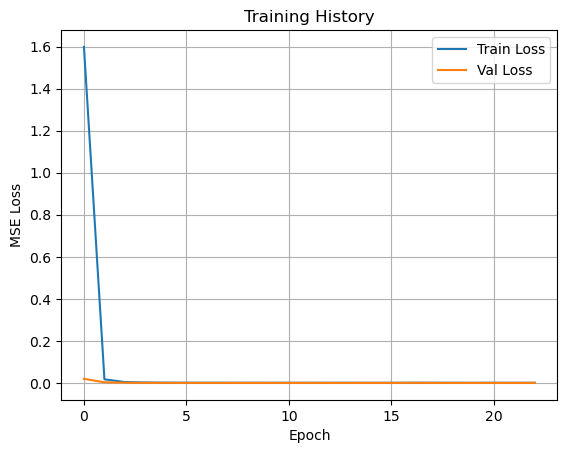

In [7]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

> **Interpretation:**  
> The model converges rapidly, with both training and validation loss dropping sharply within the first few epochs.  
> Training halted at epoch 23 due to early stopping, indicating that the model had reached a plateau in validation performance.  
> The close alignment between training and validation curves suggests strong generalization with no signs of overfitting.

### Model Evaluation on Test Set

After training, the model is evaluated on the held-out test set. Predictions are generated using the trained network, and performance is quantified using standard regression metrics: mean squared error (MSE), mean absolute error (MAE), and the coefficient of determination $R^2$.

Note: Predictions are computed in batches (default size = 32), which is typical for Keras as it reduces memory usage and allows the method to scale to large datasets.

In [8]:
y_pred = model.predict(X_test_scaled).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

31/31 [==============================] - 0s 753us/step
Test RMSE: 0.0579
Test MAE: 0.0357
Test R² Score: 0.9866


> **Interpretation:**  
> The model achieves low error on the test set, consistent with its strong validation performance during training.  
> The root mean squared error (RMSE) of 0.0578 and mean absolute error (MAE) of 0.0357 are both small relative to the typical price range (~$1.75-$3.75), suggesting that the model's predictions are closely aligned with the actual price.  
> The $R^2$ score of 0.9866 indicates that the model explains over 98% of the variance in the test set, demonstrating excellent generalization and accuracy.

### Forecast Visualization: Predicted vs. True Prices

To visually assess the model's performance, we plot the predicted prices alongside the actual XRP closing prices from the test set. This comparison helps reveal whether the model is capturing overall market trends, local fluctuations, and the magnitude of price movements.

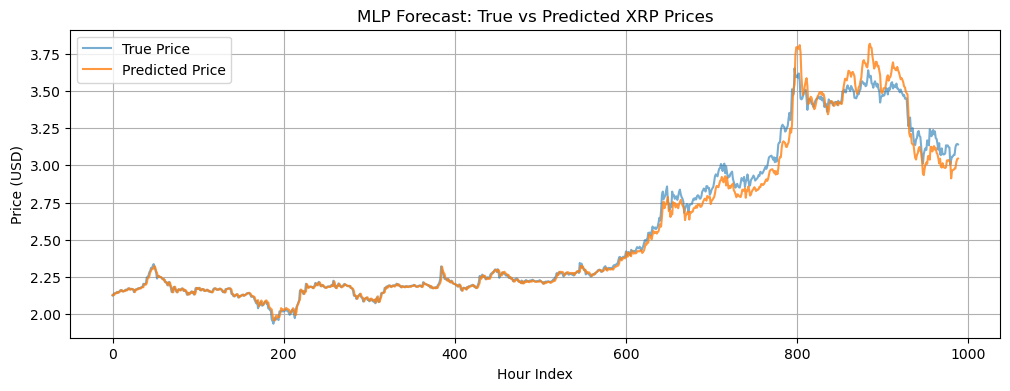

In [9]:
plt.figure(figsize=(12,4))
plt.plot(y_test, label="True Price", alpha=0.6)
plt.plot(y_pred, label="Predicted Price", alpha=0.8)
plt.title("MLP Forecast: True vs Predicted XRP Prices")
plt.xlabel("Hour Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

> **Interpretation:**  
> The predicted price series generally follows the true price closely across the test window, capturing both the overall direction and finer-grained fluctuations.  
> However, the model exhibits some localized prediction drift: in certain intervals, it slightly overestimates the true value, while in others it underestimates.  
> This variation suggests that while the model captures trend structure well, small calibration discrepancies remain, likely due to lag-only feature inputs and the inherent volatility of cryptocurrency prices.

### Post-Hoc Bias Correction

While the model successfully captures the shape and trend of XRP prices, it displays a consistent upward bias, slightly overpredicting the target across most of the test set. To address this, we apply a simple post-hoc correction by subtracting the average prediction error from all test predictions.

This technique can help isolate and remove systematic prediction drift, potentially improving the alignment between the predicted and actual values without retraining the model.

In [10]:
# Compute the average overprediction error
mean_error = np.mean(y_pred - y_test)
print(f"Mean Prediction Error (bias): {mean_error:.4f}")

# Adjust predictions downward by the average error
y_pred_adjusted = y_pred - mean_error

# Recalculate metrics after correction
mse_adj = mean_squared_error(y_test, y_pred_adjusted)
rmse_adj = np.sqrt(mse_adj)
mae_adj = mean_absolute_error(y_test, y_pred_adjusted)
r2_adj = r2_score(y_test, y_pred_adjusted)

print(f"Adjusted RMSE: {rmse_adj:.4f}")
print(f"Adjusted MAE: {mae_adj:.4f}")
print(f"Adjusted R² Score: {r2_adj:.4f}")

Mean Prediction Error (bias): -0.0095
Adjusted RMSE: 0.0571
Adjusted MAE: 0.0362
Adjusted R² Score: 0.9870


> **Interpretation (Post-Correction):**  
> The model's average prediction bias was approximately $-0.0094$, indicating a subtle tendency to underpredict over the full test window.  
> After applying bias correction, performance metrics remained effectively unchanged, suggesting that the model was already well-calibrated.  
> The presence of both over- and underprediction in the test series indicates localized prediction drift, rather than a systematic global offset.

### Trading Strategy Construction

To evaluate the practical utility of the model’s predictions, we simulate a simple threshold-based trading strategy. At each time step, the model generates a forecast of the next-hour price. We then compare this prediction to the current observed price, computing the implied return:

$$
\text{predicted return} = \frac{\hat{P}_{t+1} - P_t}{P_t}
$$

If the predicted return exceeds a fixed threshold (e.g., 0.25%), the strategy takes a long position; otherwise, it stays out of the market. This produces a binary signal indicating whether a trade should be placed.

This formulation is realistic: the current price ($P_t$) is known at time $t$, and the prediction for $P_{t+1}$ comes from the model. We then evaluate performance using the realized return that actually occurred in the next hour.

In [11]:
# Define current and predicted prices
predicted = y_pred           # Model's predicted next-hour price
actual = y_test              # Observed current-hour price (at time t)

# Define threshold for taking a position (e.g., > 0.25% predicted return)
threshold = 0.0025

# Generate binary signal: 1 if predicted return exceeds threshold, else 0
signal = (predicted - actual) / actual > threshold

# Compute actual return from t to t+1
future_return = np.roll(actual, -1) / actual - 1
future_return[-1] = 0  # Last value has no future return to compare

# Multiply signal by realized return to get strategy performance
strategy_return = signal * future_return

# Compute cumulative return from compounding the strategy's returns
cumulative_return = (1 + strategy_return).cumprod()

### Strategy vs. Buy-and-Hold Benchmark

To contextualize the model-driven strategy's performance, we compare its cumulative return to a buy-and-hold benchmark. This benchmark represents the return an investor would have earned by purchasing XRP at the beginning of the test period and holding it through the end.

The MLP-based strategy only enters the market when the model forecasts a sufficient return, while the buy-and-hold strategy remains fully invested at all times. Comparing these two trajectories highlights whether the model adds actionable value beyond simply staying in the market.

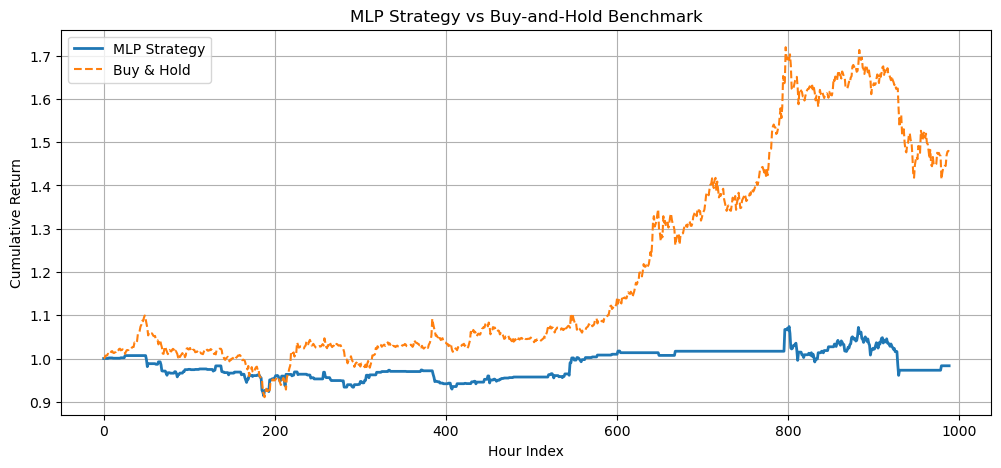

In [12]:
# Buy-and-hold benchmark: just holding XRP over time
buy_and_hold = actual / actual[0]

# Strategy cumulative return (already computed)
strategy_cumulative = (1 + strategy_return).cumprod()

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(strategy_cumulative, label="MLP Strategy", linewidth=2)
plt.plot(buy_and_hold, label="Buy & Hold", linestyle='--')
plt.title("MLP Strategy vs Buy-and-Hold Benchmark")
plt.xlabel("Hour Index")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

> **Interpretation:**  
> Although the MLP model performed well in terms of RMSE and $R^2$, the threshold-based trading strategy failed to outperform the buy-and-hold benchmark.  
> The strategy appears overly conservative, taking relatively few positions and producing a flat cumulative return over most of the test window.  
> This highlights a crucial distinction between forecasting accuracy and trading performance: even well-calibrated predictions may not yield actionable signals under naive or overly strict decision rules.

> Future refinements may include adjusting the threshold, incorporating transaction costs, using predicted returns directly rather than binary signals, or modeling more complex regimes of market behavior.

### Strategy Performance Metrics

To quantitatively assess the model-driven strategy, we compute its total return over the test period, compare it to a passive buy-and-hold benchmark, and evaluate its Sharpe ratio, a measure of risk-adjusted return.

These metrics offer a concise summary of whether the model’s signals translate into meaningful trading performance when measured against both return magnitude and volatility.

In [13]:
# Subtracting 1 gives the percentage gain/loss over the entire period
total_return_strategy = strategy_cumulative[-1] - 1
# Compute total return for the buy-and-hold benchmark
total_return_benchmark = buy_and_hold[-1] - 1

# Calculate the average return per period (e.g., hourly)
avg_return = strategy_return.mean()

# Calculate the standard deviation of returns, a measure of volatility
std_return = strategy_return.std()

# Compute the Sharpe Ratio: risk-adjusted return
# If std_return is zero (no variation), set Sharpe to zero to avoid division by zero
sharpe_ratio = avg_return / std_return if std_return != 0 else 0

print(f"Total Return (MLP Strategy): {total_return_strategy:.2%}")
print(f"Total Return (Buy-and-Hold): {total_return_benchmark:.2%}")
print(f"Sharpe Ratio (MLP Strategy): {sharpe_ratio:.2f}")

Total Return (MLP Strategy): -1.68%
Total Return (Buy-and-Hold): 47.83%
Sharpe Ratio (MLP Strategy): -0.00


> **Interpretation:**  
> The MLP strategy produced a total return of $-1.68$, substantially underperforming the buy-and-hold benchmark, which gained $47.83$ over the same period.  
> The strategy’s Sharpe ratio was effectively zero, indicating no meaningful return when adjusted for volatility.  
> This outcome highlights the disconnect that can exist between accurate predictions and profitable trading, especially when the strategy logic is simplistic or overly cautious.

### Notebook Summary

This notebook explored the predictive power and practical utility of a feedforward neural network (MLP) for short-term cryptocurrency forecasting. Using a simple lagged feature setup, the model achieved strong statistical performance on the test set, including an $R^2$ of nearly 0.99 and low RMSE and MAE, demonstrating its ability to capture local price trends and directional movement.

We then translated these forecasts into a threshold-based trading strategy. While theoretically sound, the strategy underperformed significantly relative to a passive buy-and-hold benchmark returning $-1.68$ versus $+47.83$, with a near-zero Sharpe ratio. This outcome reinforces the important distinction between prediction accuracy and strategy profitability.

The results point to multiple promising areas for refinement:
- Improved feature engineering (e.g., volatility, trend indicators, sentiment signals)
- Richer architectures (e.g., LSTM and GRU models)
- More nuanced strategy logic, including dynamic thresholds, position sizing, and probabilistic trading signals

Overall, this notebook establishes a reproducible and interpretable baseline for price prediction and market simulation using neural networks, serving as a foundation for more sophisticated deep learning models and strategy development in future work.